In [1]:
library(Seurat)
library(ggplot2)
library(enrichR)
library(stringr)
library(RColorBrewer)
library(pheatmap)
library(dplyr)
library(scales)
library(dplyr)
library(ComplexHeatmap)
library(circlize)
library(tidyr)
library(tibble)
library(grid)

Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.3.3”



Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is Live!

WormEnrichr ... 
Connection is Live!

YeastEnrichr ... 
Connection is Live!

FishEnrichr ... 
Connection is Live!

OxEnrichr ... 
Connection is Live!

Warning message:
“package ‘RColorBrewer’ was built under R version 4.3.3”
Warning message:
“package ‘pheatmap’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ComplexHeatmap’ was built under R version 4.3.2”
Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Gith

In [ ]:
ifnb = readRDS("hc_rbd_pd_joint_integrated.rds")

In [4]:
ifnb_testct <- ifnb

In [4]:
ifnb_testct

An object of class Seurat 
36601 features across 231216 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 3 dimensional reductions calculated: pca, integrated.cca, umap

In [7]:
dim(ifnb_testct)

[1]  36601 231216

# Exporting data for scCODA

In [ ]:
meta_df <- ifnb_testct@meta.data
# Create count matrix grouped by batch and disease
count_matrix <- meta_df %>%
  group_by(batch, disease, celltype) %>%
  summarise(count = n(), .groups = "drop") %>%
  pivot_wider(
    names_from = celltype,
    values_from = count,
    values_fill = list(count = 0)  # fill missing celltypes with 0
  )

# Save to CSV
write.csv(count_matrix, file = "../../data/celltype_counts_by_batch_disease.csv", row.names = FALSE)

# Exploratory plots and tables

In [ ]:
# clustering
ifnb_testct <- FindNeighbors(ifnb_testct, reduction = "integrated.cca", dims = 1:30)
ifnb_testct <- FindClusters(ifnb_testct, resolution = 0.5)
ifnb_testct <- RunUMAP(ifnb_testct, dims = 1:30, reduction = "integrated.cca")

Computing nearest neighbor graph

Computing SNN



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



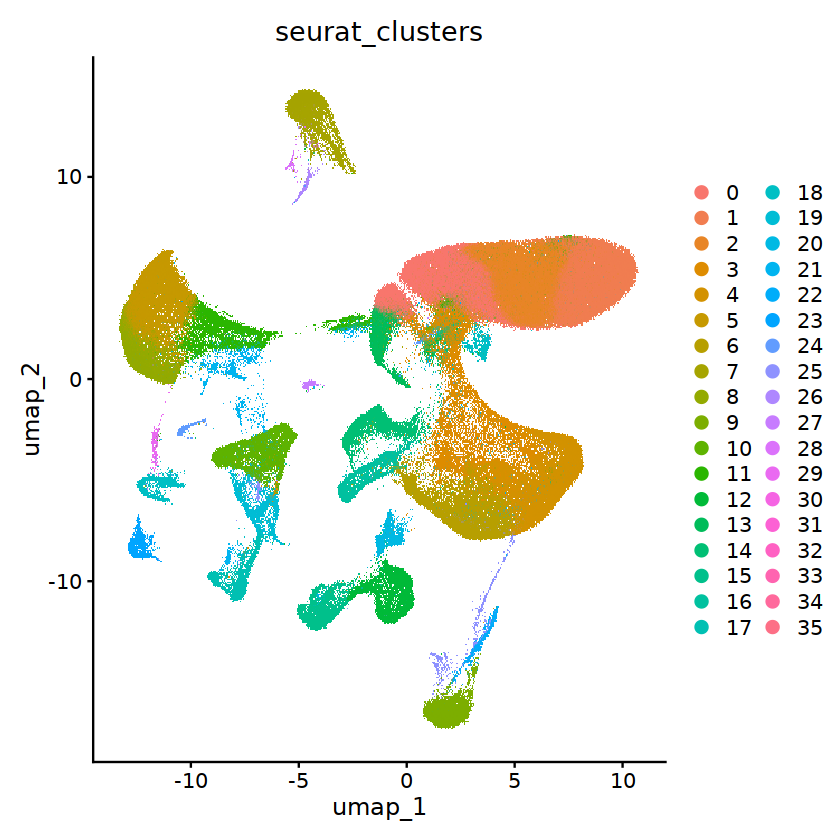

In [5]:
DimPlot(ifnb_testct, reduction = "umap", group.by = c("seurat_clusters"))

In [5]:
# Rename cell types in the 'celltype' column
ifnb_testct@meta.data$celltype <- recode(ifnb_testct@meta.data$celltype,
  "astrocytes" = "Ast",
  "endothelia cells" = "Endo",
  "excitatory neurons" = "ExN",
  "inhibitory neurons" = "InN",
  "microglia" = "Mic",
  "oligodendrocyte precursor cells" = "OPC",
  "oligodendrocytes" = "Oli",
  "pericytes" = "Peri"
)

In [ ]:
library(RColorBrewer)

# Generate Dark2 colors (up to 8 distinct colors)
my_colors <- brewer.pal(n = 8, name = "Dark2")

# If you have more than 8 groups, use colorRampPalette to interpolate more colors
n_groups <- length(unique(ifnb_testct$celltype))
my_colors <- colorRampPalette(brewer.pal(8, "Dark2"))(n_groups)

pdf("../../man_figs_pdf/all_umap_celltype.pdf", width = 16, height = 16)  # Adjust width and height as needed
# Plot with custom colors
DimPlot(ifnb_testct, reduction = "umap", group.by = "celltype", cols = my_colors, raster=FALSE)
dev.off()

pdf 
  2

In [ ]:
library(Seurat)
library(ggplot2)
library(RColorBrewer)
library(dplyr)

# Get celltype info
celltypes_vector <- ifnb_testct$celltype
celltype_counts <- as.data.frame(table(celltypes_vector))
colnames(celltype_counts) <- c("celltype", "count")

# Define original bottom-to-top (alphabetical) order
sorted_levels <- sort(unique(celltype_counts$celltype))

# Use Dark2 palette based on original order
n_colors <- length(sorted_levels)
colors <- colorRampPalette(brewer.pal(8, "Dark2"))(n_colors)
names(colors) <- sorted_levels  # name the colors to preserve mapping

# Reverse order for top-to-bottom plotting
celltype_counts$celltype <- factor(celltype_counts$celltype, levels = rev(sorted_levels))

# Add percentage and label
celltype_counts <- celltype_counts %>%
  mutate(percent = count / sum(count) * 100,
         label = paste0(count, " (", sprintf("%.1f", percent), "%)"))

pdf("../../man_figs_pdf/all_celltype_barplot.pdf", width = 8, height = 8)
# Plot
ggplot(celltype_counts, aes(x = count, y = celltype, fill = celltype)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = label), hjust = -0.1, size = 3.5) +
  scale_fill_manual(values = colors) +  # mapping based on names, so stays correct
  labs(x = "Number of cells", y = "Cell type", title = "Cell Counts by Cell Type") +
  theme_minimal() +
  theme(legend.position = "none") +
  coord_cartesian(xlim = c(0, max(celltype_counts$count) * 1.1))
dev.off()

pdf 
  2

In [ ]:
library(openxlsx)
#––– Counts & proportions ––––––––––––––––––––––––––––––
celltypes_vector <- ifnb_testct$celltype
celltype_counts  <- as.data.frame(table(celltypes_vector))
colnames(celltype_counts) <- c("celltype", "count")

# Keep a tidy numeric proportion column (0–1) **before** formatting for plotting
celltype_counts <- celltype_counts |>
  mutate(proportion = count / sum(count))

#––– Excel export ––––––––––––––––––––––––––––––––––––––
wb <- createWorkbook()
addWorksheet(wb, "Celltype Counts")

# Prepare data frame for export (with nice headers)
export_df <- celltype_counts |>
  mutate(Proportion = round(proportion, 4)) |>
  select(celltype, count, Proportion)

# Write the data to sheet
writeData(wb, sheet = "Celltype Counts", x = export_df)

# Save Excel file
saveWorkbook(wb, file = "../../man_supp_tables/all_ct/all_celltype_summary.xlsx", overwrite = TRUE)

In [ ]:
pdf("../../man_figs_pdf/all_celltype_umap_disease.pdf", width = 16, height = 16)
custom_colors <- c("#00BA38", "#F8766D", "#619CFF")
DimPlot(ifnb_testct, reduction = "umap", group.by = c("disease"), alpha=0.5, cols = custom_colors, pt.size = 0.1, raster=FALSE)
dev.off()

pdf 
  2

In [ ]:
library(dplyr)
library(stringr)
# Extract metadata from the Seurat object
metadata <- as.data.frame(ifnb_testct@meta.data)

# Filter the metadata for specified cell types
filtered_metadata <- metadata

# Calculate proportions for each cell type per individual
proportion_data <- filtered_metadata %>%
  group_by(batch, celltype) %>%
  summarise(cell_count = n(), .groups = 'drop') %>%
  group_by(batch) %>%
  mutate(total_cells = sum(cell_count),
         proportion = cell_count / total_cells) %>%
  ungroup()

# Add disease information to the proportions
proportion_data <- proportion_data %>%
  left_join(metadata %>% distinct(batch, disease), by = "batch")

proportion_data$disease <- factor(proportion_data$disease, levels = c("HC", "RBD", "PD"))

# Define custom colors
custom_colors <- c("HC" = "#00BA38", "RBD" = "#619CFF", "PD" = "#F8766D")

pdf("../../man_figs_pdf/allct_prop_disease_boxplot.pdf", width = 16, height = 10)  # Adjust width and height as needed
# Reorder seurat_clusters to be plotted with 0 at the top
proportion_data$celltype <- factor(proportion_data$celltype, 
                                          levels = rev(sort(unique(proportion_data$celltype))))

# Create boxplot with reordered y-axis
ggplot(proportion_data, aes(y = celltype, x =
                            proportion, fill = disease)) +
  geom_boxplot(outlier.shape = 16, outlier.size = 1) +  # Show outliers with default points
  scale_fill_manual(values = custom_colors) +  # Apply custom colors
  labs(title = "Proportion of Cell Types Across Disease Groups",
       y = "Cell type",  # Now on y-axis
       x = "Proportion",        # Now on x-axis
       fill = "Disease Group") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 12))  # Adjust y-axis text size for clarity

dev.off()

pdf 
  2

In [ ]:
# Create workbook
wb <- createWorkbook()

# Add a worksheet
addWorksheet(wb, "Celltype Proportions by Sample")

# Extract metadata from the Seurat object
metadata <- as.data.frame(ifnb_testct@meta.data)

# Filter the metadata for specified cell types
filtered_metadata <- metadata

# Calculate proportions for each cell type per individual
proportion_data <- filtered_metadata %>%
  group_by(batch, celltype) %>%
  summarise(cell_count = n(), .groups = 'drop') %>%
  group_by(batch) %>%
  mutate(total_cells = sum(cell_count),
         proportion = cell_count / total_cells) %>%
  ungroup()

# Add disease information to the proportions
proportion_data <- proportion_data %>%
  left_join(metadata %>% distinct(batch, disease), by = "batch")

proportion_data$disease <- factor(proportion_data$disease, levels = c("HC", "RBD", "PD"))

# Select and reorder columns for clarity
export_df <- proportion_data %>%
  select(batch, disease, celltype, cell_count, total_cells, proportion) %>%
  rename(sample = batch)

export_df$proportion <- round(export_df$proportion, 4)

# Write the data to the worksheet
writeData(wb, sheet = "Celltype Proportions by Sample", x = export_df)

# Save the workbook
saveWorkbook(wb, file = "../../man_supp_tables/all_ct/celltype_proportions_by_sample.xlsx", overwrite = TRUE)

# Identifying Marker Genes

## For each Seurat Cluster

In [15]:
set.seed(384)
cluster_markers <- list()
cluster_sizes <- table(Idents(ifnb_testct))

for (i in 0:35) {
  if (cluster_sizes[as.character(i)] >= 3) {  # Check if cluster has at least 3 cells
    cluster_markers[[paste0("Cluster_", i)]] <- FindMarkers(ifnb_testct, ident.1 = i)
  } else {
    cluster_markers[[paste0("Cluster_", i)]] <- NA  # Store NA for reference
    message(paste("Skipping cluster", i, "due to insufficient cells"))
  }
}

Skipping cluster 30 due to insufficient cells

Skipping cluster 31 due to insufficient cells

Skipping cluster 32 due to insufficient cells

Skipping cluster 33 due to insufficient cells

Skipping cluster 34 due to insufficient cells

Skipping cluster 35 due to insufficient cells



In [24]:
cluster_markers[[paste0("Cluster_", 0)]]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CELF2,0,-5.505060,0.051,0.681,0
SLC5A11,0,2.510410,0.781,0.163,0
KCNMA1,0,-5.039143,0.050,0.661,0
MOBP,0,1.830265,0.952,0.355,0
SLCO1A2,0,1.709376,0.903,0.308,0
ENPP2,0,1.683868,0.946,0.354,0
ST18,0,1.773470,0.997,0.408,0
ANLN,0,1.833913,0.866,0.278,0
FAM155A,0,-5.378975,0.075,0.662,0


In [ ]:
library(openxlsx)

# Create a new workbook
wb <- createWorkbook()

for (i in 0:35) {
    if (!is.null(cluster_markers[[paste0("Cluster_", i)]]) && is.data.frame(cluster_markers[[paste0("Cluster_", i)]])) {
        # Filter the data for each cluster
        cluster_data <- cluster_markers[[paste0("Cluster_", i)]] %>% filter(p_val_adj < 0.05) %>% filter(avg_log2FC > 0.25)
        
        # Add a worksheet with the cluster name
        addWorksheet(wb, sheetName = paste0("Cluster_", i))
        
        # Write the filtered data to the worksheet
        writeData(wb, sheet = paste0("Cluster_", i), cluster_data, rowNames = TRUE)
    } else {
        print(paste("Skipping Cluster_", i, "as it is not a valid data frame."))
    }
}

# Save the workbook to an Excel file
saveWorkbook(wb, file = "../../Annotate_All/36_clusters/Marker_Genes.xlsx", overwrite = TRUE)

[1] "Skipping Cluster_ 30 as it is not a valid data frame."
[1] "Skipping Cluster_ 31 as it is not a valid data frame."
[1] "Skipping Cluster_ 32 as it is not a valid data frame."
[1] "Skipping Cluster_ 33 as it is not a valid data frame."
[1] "Skipping Cluster_ 34 as it is not a valid data frame."
[1] "Skipping Cluster_ 35 as it is not a valid data frame."


## For each celltype

In [ ]:
Idents(ifnb_testct) <- ifnb_testct$celltype
celltype_markers <- FindAllMarkers(ifnb_testct, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.csv(celltype_markers, "../../Annotate_All/celltype_markers.csv", row.names = FALSE)

Calculating cluster excitatory neurons

Calculating cluster oligodendrocyte precursor cells

Calculating cluster oligodendrocytes

Calculating cluster inhibitory neurons

Calculating cluster astrocytes

Calculating cluster microglia

Calculating cluster endothelia cells

Calculating cluster pericytes



In [ ]:
library(dplyr)
significant_markers <- celltype_markers %>% filter(p_val_adj < 0.05)
write.csv(significant_markers, "../../Annotate_All/significant_celltype_markers.csv", row.names = FALSE)